In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# 1. Charger les données
df = pd.read_csv("dvf_clean.csv")

# ...existing code...
# Encodage one-hot pour code_type_local et type_local
df = pd.get_dummies(df, columns=["code_type_local", "type_local"], drop_first=True)


C:\Users\Ethan\AppData\Local\Temp\ipykernel_5704\1882263619.py:8: DtypeWarning: Columns (10,12,14,16,17,18,20,22,24,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dvf_clean.csv")


In [27]:
# 2. Exploration rapide
print(df.head())
print(df.info())
print(df.describe())
print("Types de bâtiments présents dans le dataset :")
print("Moyenne des prix (valeur_fonciere) :", df["valeur_fonciere"].mean())
# 3. Nettoyer les données
# Retirer les colonnes inutiles ou vides
df = df.dropna(subset=["valeur_fonciere"])  # retire les lignes sans prix
df = df.sample(frac=0.01, random_state=42).reset_index(drop=True)

  id_mutation date_mutation  numero_disposition nature_mutation  \
0      2020-1    2020-01-07                   1           Vente   
1      2020-2    2020-01-02                   1           Vente   
2      2020-2    2020-01-02                   1           Vente   
3      2020-2    2020-01-02                   1           Vente   
4      2020-2    2020-01-02                   1           Vente   

   valeur_fonciere  adresse_numero adresse_suffixe        adresse_nom_voie  \
0           8000.0             NaN             NaN                FORTUNAT   
1           2175.0             NaN             NaN  TERRES DES CINQ SAULES   
2           2175.0             NaN             NaN      BOIS DU CHAMP RION   
3           2175.0             NaN             NaN             EN COROBERT   
4           2175.0             NaN             NaN  TERRES DES CINQ SAULES   

  adresse_code_voie  code_postal  ... nature_culture_speciale surface_terrain  \
0              B063       1250.0  ...          

In [28]:
cols_to_use = [
    "surface_reelle_bati", "nombre_pieces_principales",
    "surface_terrain", "code_postal", "code_type_local", "type_local"
]

# Préparation des features finales
X = df[["surface_reelle_bati", "nombre_pieces_principales", "surface_terrain", "code_postal"] + 
       [col for col in df.columns if col.startswith("code_type_local_") or col.startswith("type_local_")]].fillna(0)

y = df["valeur_fonciere"]
# ...existing code...


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 6. Création du modèle Random Forest
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train, y_train)

,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
# 6. Création du modèle Random Forest
model = RandomForestRegressor(n_estimators=20)
model.fit(X_train, y_train)

# 7. Prédictions
y_pred = model.predict(X_test)

In [31]:
# 8. Évaluation
mae_test = mean_absolute_error(y_test, y_pred)
y_train_pred = model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_test, y_pred)

In [32]:
print(f"MAE (Mean Absolute Error) - Test : {mae_test}")
print(f"MAE (Mean Absolute Error) - Train : {mae_train}")
print(f"R² score : {r2}")

MAE (Mean Absolute Error) - Test : 1263787.5229768234
MAE (Mean Absolute Error) - Train : 577501.7315768612
R² score : 0.6063907877326108


<Axes: title={'center': 'Importance des variables'}>

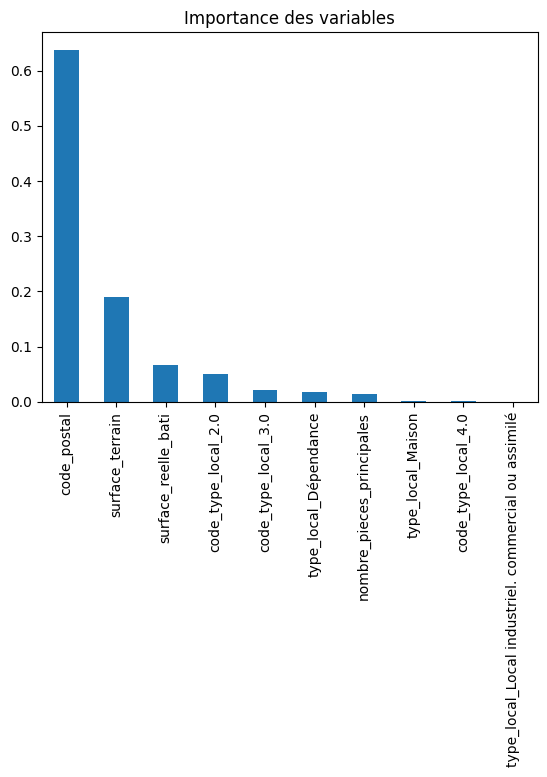

In [33]:
# 9. Réduire la taille de la base pour les tests (prend 1% des données)
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind="bar", title="Importance des variables")
